In [1]:
from artifacts_ipv6_sra_scanning.config import *
import pickle
import os
import ipaddress
import geopandas as gpd
import seaborn as sns
import glob
import pycountry
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=24, split_factor=1, disable_pr_bar=False)

2025-09-27 20:59:46.182 | INFO     | artifacts_ipv6_sra_scanning.config:<module>:22 - PROJ_ROOT path is: /home/service/artifacts-ipv6-sra-scanning


In [2]:
def load_and_join(files,column):
    df_metadata = pl.read_csv(f'{INTERIM_DATA_DIR}/router-ips.csv')
    df = pl.DataFrame()
    for i in tqdm(range(len(files))):
        if df.is_empty():
            df = pl.read_csv(files[i],columns=['initial-ip','saddr']).unique(subset=['initial-ip'])
            df = df.join(df_metadata.select(['ip-addr',column]),how='left',left_on='saddr',right_on='ip-addr')
            df = df.select(column).unique()
            df = df.with_columns(inscan=True)
        else:
            tmp = pl.read_csv(files[i],columns=['initial-ip','saddr']).unique(subset=['initial-ip'])
            tmp = tmp.join(df_metadata.select(['ip-addr',column]),how='left',left_on='saddr',right_on='ip-addr')
            tmp = tmp.select(column).unique()
            tmp = tmp.with_columns(inscan=True)
            df = df.join(tmp,on=column,how='full', suffix=f'_s{i}',coalesce=True)
    return df

In [3]:
datadir = '/home/service/ipv6-measurements-mkoch/backup_2024/sra-analysis/data/tuminput_sra_checks'

In [4]:
files = glob.glob(f'{datadir}/zmap_icmp_tum_64_sra_*.log.zst')

In [5]:
files

['/home/service/ipv6-measurements-mkoch/backup_2024/sra-analysis/data/tuminput_sra_checks/zmap_icmp_tum_64_sra_1731694726.log.zst',
 '/home/service/ipv6-measurements-mkoch/backup_2024/sra-analysis/data/tuminput_sra_checks/zmap_icmp_tum_64_sra_1731701324.log.zst',
 '/home/service/ipv6-measurements-mkoch/backup_2024/sra-analysis/data/tuminput_sra_checks/zmap_icmp_tum_64_sra_1731710705.log.zst',
 '/home/service/ipv6-measurements-mkoch/backup_2024/sra-analysis/data/tuminput_sra_checks/zmap_icmp_tum_64_sra_1731755399.log.zst',
 '/home/service/ipv6-measurements-mkoch/backup_2024/sra-analysis/data/tuminput_sra_checks/zmap_icmp_tum_64_sra_1731762017.log.zst',
 '/home/service/ipv6-measurements-mkoch/backup_2024/sra-analysis/data/tuminput_sra_checks/zmap_icmp_tum_64_sra_1731765056.log.zst']

In [6]:
df = load_and_join(files,'BGP-Prefix')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:16<00:00, 52.68s/it]


In [7]:
df

BGP-Prefix,inscan,inscan_s1,inscan_s2,inscan_s3,inscan_s4,inscan_s5
str,bool,bool,bool,bool,bool,bool
"""2804:34cc::/32""",true,true,true,true,true,true
"""2804:3184:100::/40""",true,true,true,true,true,true
"""2409:8754:6c00::/40""",true,true,true,true,true,true
"""2408:8459:e270::/44""",true,true,true,true,true,true
"""2405:4802:c0b0::/44""",true,true,null,null,null,null
…,…,…,…,…,…,…
"""2602:fed2:730c::/48""",null,null,null,null,null,true
"""2806:230:4026::/48""",null,null,null,null,null,true
"""2c0f:fc88:3e::/48""",null,null,null,null,null,true


In [8]:
df = df.with_columns(
    df.select(pl.exclude("BGP-Prefix"))
      .cast(pl.Int8)  # convert True->1, null->0
      .sum_horizontal()
      .alias("seen_count")
)

In [9]:
n_scans = df.select(pl.exclude(["BGP-Prefix","seen_count"])).width
df = df.with_columns(
    (pl.col("seen_count") / n_scans).alias("seen_ratio")
)

In [10]:
def count_flips(series: pl.Series) -> int:
    vals = [bool(v) for v in series if v is not None]
    return sum(1 for a, b in zip(vals, vals[1:]) if a != b)

df = df.with_columns(
    pl.struct(pl.exclude(["BGP-Prefix",'seen_count','seen_ratio']))
      .map_elements(lambda s: count_flips(list(s.values())))
      .alias("flip_count")
)

/tmp/ipykernel_862967/3869511051.py:5: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(


In [11]:
df

BGP-Prefix,inscan,inscan_s1,inscan_s2,inscan_s3,inscan_s4,inscan_s5,seen_count,seen_ratio,flip_count
str,bool,bool,bool,bool,bool,bool,i8,f64,i64
"""2804:34cc::/32""",true,true,true,true,true,true,6,1.0,0
"""2804:3184:100::/40""",true,true,true,true,true,true,6,1.0,0
"""2409:8754:6c00::/40""",true,true,true,true,true,true,6,1.0,0
"""2408:8459:e270::/44""",true,true,true,true,true,true,6,1.0,0
"""2405:4802:c0b0::/44""",true,true,null,null,null,null,2,0.333333,0
…,…,…,…,…,…,…,…,…,…
"""2602:fed2:730c::/48""",null,null,null,null,null,true,1,0.166667,0
"""2806:230:4026::/48""",null,null,null,null,null,true,1,0.166667,0
"""2c0f:fc88:3e::/48""",null,null,null,null,null,true,1,0.166667,0


In [12]:
total = len(df)
seen_ratio = df.group_by("seen_count").agg(
    pl.len().alias('count'),
    (pl.len()/total).mul(100).alias('relative')
).sort('seen_count')

In [13]:
seen_ratio

seen_count,count,relative
i8,u32,f64
1,1088,2.188122
2,1488,2.992579
3,1712,3.443075
4,787,1.582769
5,1285,2.584317
6,43363,87.209139


In [14]:
heatmap_data = seen_ratio.select(['seen_count','relative']).to_pandas().set_index('seen_count').T#.transpose(column_names='seen_count')

In [15]:
plt.rc("font", size=12)

/home/service/artifacts-ipv6-sra-scanning/reports/figures/sra-prefix-stability.png


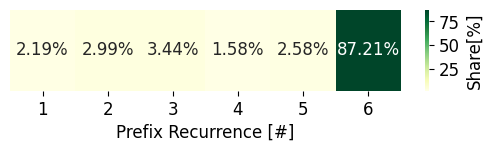

In [19]:
figsize = (9*0.7,1.5*0.7)
fig,ax = vh.fig_ax(figsize)

annot_labels = heatmap_data.map(lambda x: f"{x:.2f}%")

sns.heatmap(heatmap_data,
            ax=ax,
            fmt="",
            linecolor='white',
            cmap="YlGn",
            annot=annot_labels,
            cbar_kws={'label': 'Share[%]',"orientation": "vertical","shrink":1,'location':'right'})

ax.set_xlabel('Prefix Recurrence [#]')
ax.set_yticks([])

vh.save_plot(fig,'sra-prefix-stability')